In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import HTML

In [2]:

import numpy as np
import os
import data_utils
import pickle
import random
from keras.models import load_model

Using TensorFlow backend.


In [3]:
TOKENIZER_PATH = 'tokenizer.pickle'
TEXT_DATA_DIR = '20_newsgroup/'
MODEL_PATH = '20news_model.h5'

In [4]:
tokenizer, inverse_tokenizer = data_utils.load_tokenizer(TOKENIZER_PATH)
model = load_model(MODEL_PATH)
labels =  list(sorted(os.listdir(TEXT_DATA_DIR)))

In [184]:
sample_file, true_label = data_utils.pick_random_file(TEXT_DATA_DIR)
sample_file = '20_newsgroup/talk.politics.guns/54516'
true_label = 'talk.politics.guns'
file_text = data_utils.load_textfile(sample_file)
file_features = data_utils.process_text(tokenizer, file_text)

In [185]:
pred_scores = model.predict(file_features)
orig_prediction = np.argmax(pred_scores[0])
print(sample_file)
print('TrueLabel = %s' %true_label)
print('Predicted "%s" with %f .' %(labels[orig_prediction], pred_scores[0][orig_prediction]))

20_newsgroup/talk.politics.guns/54516
TrueLabel = talk.politics.guns
Predicted "talk.politics.guns" with 0.165192 .


## Random Attack (Non-targeted)

 Random attack will pick and replace words randomly.

In [186]:
num_words = len(tokenizer.word_index)

In [187]:
y_orig = []
x_adv = file_features.copy()
orig_pred = orig_prediction
iter_idx = -1
orig_history_rd = []
while True:
    iter_idx += 1
    # perturb another random word
    word_idx = np.random.choice(len(x_adv[0]))
    while x_adv[0][word_idx] == 0:
        # don't perturb paddings
        word_idx = np.random.choice(len(x_adv[0]))
    # select new word
    x_adv[0][word_idx] = np.random.choice(num_words)
    pred_scores = model.predict(x_adv)
    orig_history_rd.append(pred_scores[0][orig_pred])
    new_pred = np.argmax(pred_scores)
    y_orig.append(pred_scores[0][orig_pred])
    if new_pred != orig_pred:
        # Attack done !
        break
print("Attack successful after : %d iterations" %(iter_idx))
num_changed = np.count_nonzero(file_features!=x_adv)
num_features = np.count_nonzero(file_features)
print("Number of changed words = %d (%0.3f %%)"
      %(num_changed, 100.0*float(num_changed)/num_features))
print("Original class \"%s\" - New class: \"%s\"" %(labels[orig_pred], labels[new_pred]))

Attack successful after : 267 iterations
Number of changed words = 144 (71.287 %)
Original class "talk.politics.guns" - New class: "comp.graphics"


## Reconstruct Text Document

In [188]:
orig_text = data_utils.reconstruct_text(inverse_tokenizer, file_features[0])
adv_text = data_utils.reconstruct_text(inverse_tokenizer, x_adv[0])

## Visualize Attack

In [189]:
orig_html, adv_html = data_utils.render_attack(orig_text, adv_text)

In [190]:
HTML("<b> Original Text </b>")
HTML(orig_html)

In [191]:
HTML("<b> Adversarial Text </b>")
HTML(adv_html)

## Greedy Attack

Greedy Method // choose random word and change it to the words with high probability in goal class

In [192]:
y_orig = []
x_adv = file_features.copy()
orig_pred = orig_prediction
iter_idx = -1
orig_history_gd = []
target_history_gd = []
label_dic = {}
label_ind = 0
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    label_dic[name] = label_ind
    label_ind = label_ind + 1

dic = pickle.load(open('probability_dic.p','rb'))
class_original = label_dic[true_label]


#randomly select another class as goal
class_goal = random.randint(0, 19)
class_goal = 4
while class_goal == class_original:
    class_goal = random.randint(0, 19)
#select next class as goal
#class_goal = (class_original+1)%20
print("target class: %s" %(labels[class_goal]))

prob_original = [0 if i == 0 else 0.05 if inverse_tokenizer[i] not in dic else dic[inverse_tokenizer[i]][class_original] for i in x_adv[0]]
to_replace = sorted(range(len(prob_original)), key=lambda k: prob_original[k], reverse=True)
prob_goal = sorted(dic, key=lambda k: dic[k][class_goal], reverse=True)

idx_target = 0
flag_change = False

while True:
    iter_idx += 1
    # sequentially choose word with higest p(original class|word) in the original text
    # and sequentially change it to word with highest p(goal class|word)
    idx_find = 0
    if iter_idx < len(x_adv[0]) and x_adv[0][to_replace[iter_idx]]!=0:
        word_idx = to_replace[iter_idx]
    else:
        word_idx = np.random.choice(len(x_adv[0]))
        while x_adv[0][word_idx] == 0:
            # don't perturb paddings
            word_idx = np.random.choice(len(x_adv[0]))
    while prob_goal[idx_target] not in tokenizer.word_index:
        idx_target = idx_target + 1
        if(idx_target > 300):
            idx_target = 0
    x_adv[0][word_idx] = tokenizer.word_index[prob_goal[idx_target]]
    idx_target = idx_target + 1
    if idx_target > 200:
        idx_target = 0
    pred_scores = model.predict(x_adv)
    orig_history_gd.append(pred_scores[0][orig_pred])
    target_history_gd.append(pred_scores[0][class_goal])
    new_pred = np.argmax(pred_scores)
    y_orig.append(pred_scores[0][orig_pred])
    if new_pred != orig_pred and flag_change == False:
        iter_temp = iter_idx
        x_adv_temp = x_adv.copy()
        num_changed_temp = np.count_nonzero(file_features!=x_adv_temp)
        pred_temp = new_pred
        flag_change = True
    if new_pred == class_goal:
        break
print("Attack change to predicted class to another class after : %d iterations" %(iter_temp))
num_features = np.count_nonzero(file_features)
print("Number of changed words = %d (%0.3f %%)"
      %(num_changed_temp, 100.0*float(num_changed_temp)/num_features))
print("Original class \"%s\" - New class: \"%s\"" %(labels[orig_pred], labels[pred_temp]))
print("Attack change to predicted class to TARGET class after : %d iterations" %(iter_idx))
num_changed = np.count_nonzero(file_features!=x_adv)
print("Number of changed words = %d (%0.3f %%)"
      %(num_changed, 100.0*float(num_changed)/num_features))
print("Original class \"%s\" - New class: \"%s\"" %(labels[orig_pred], labels[new_pred]))
plt.plot(orig_history_gd, 'g', label=labels[orig_pred]+ ' - greedy attack')
plt.plot(target_history_gd, 'r', label=labels[class_goal] + ' greedy attack')
plt.legend()

target class: comp.sys.mac.hardware


KeyboardInterrupt: 

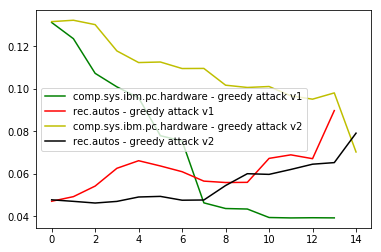

In [182]:
plt.plot(orig_history_gd, 'g', label=labels[orig_pred]+ ' - greedy attack v1')
plt.plot(target_history_gd, 'r', label=labels[class_goal]+ ' - greedy attack v1')

with open('ohist.p', 'rb') as handle:
        o_hist = pickle.load(handle)
with open('thist.p', 'rb') as handle:
        t_hist = pickle.load(handle)
plt.plot(o_hist, 'y', label=labels[orig_pred]+ ' - greedy attack v2')
plt.plot(t_hist, 'k', label=labels[class_goal]+ ' - greedy attack v2')

plt.legend()


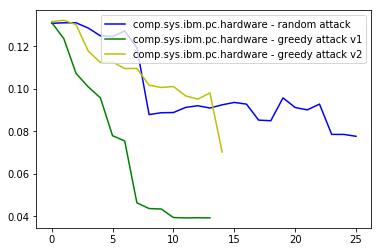

In [183]:
plt.plot(orig_history_rd, 'b', label=labels[orig_pred]+' - random attack')
plt.plot(orig_history_gd, 'g', label=labels[orig_pred]+ ' - greedy attack v1')
plt.plot(o_hist, 'y', label=labels[orig_pred]+ ' - greedy attack v2')
plt.legend()

In general, to cause the model to change the prediction, the greedy attack takes less iterations (because it chooses the word that contribute higher to the labelling of original text to perturb) than random attack.  However, when the prediction first changed, its prediction is usually not the target class (most of the times it's same as the prediction of the random attack after its first change), and it'll take more iterations for the model to predict it as the target class.

## Reconstruct Text Document

In [85]:
orig_text = data_utils.reconstruct_text(inverse_tokenizer, file_features[0])
adv_text_first_change = data_utils.reconstruct_text(inverse_tokenizer, x_adv_temp[0])

## Visualize Attack

In [86]:
orig_html, adv_1stchange_html = data_utils.render_attack(orig_text, adv_text_first_change)

In [87]:
HTML("<b> Original Text </b>")
HTML(orig_html)

In [88]:
HTML("<b> Adversarial Text (change to another class, not necessarily the target class) </b>")
HTML(adv_1stchange_html)

In [69]:
adv_text = data_utils.reconstruct_text(inverse_tokenizer, x_adv[0])
orig_html, adv_html = data_utils.render_attack(orig_text, adv_text)

In [70]:
HTML("<b> Adversarial Text (target class) </b>")
HTML(adv_html)